In [1]:
# ============================================
# MoCo (v2-style) Training + Eval on Malimg
# ============================================

import os
import random
import shutil
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image


In [2]:
# -----------------------------
# 0) Repro / Device
# -----------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True


In [3]:
# -----------------------------
# 1) Paths & Split (train/test only)
# -----------------------------
root_dir = "/kaggle/input/malimg-original/malimg_paper_dataset_imgs"
working_dir = "/kaggle/working/Malimg_split_moco"

train_ratio, test_ratio = 0.8, 0.2
splits = ["train", "test"]
IMAGE_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

os.makedirs(working_dir, exist_ok=True)
for s in splits:
    os.makedirs(os.path.join(working_dir, s), exist_ok=True)

needs_split = any(len(os.listdir(os.path.join(working_dir, s))) == 0 for s in splits)

if needs_split:
    for cls in sorted(os.listdir(root_dir)):
        class_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(class_dir):
            continue

        images = [os.path.join(class_dir, f)
                  for f in os.listdir(class_dir)
                  if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(IMAGE_EXTS)]

        if len(images) == 0:
            images = [p for p in glob(os.path.join(class_dir, "**", "*"), recursive=True)
                      if os.path.isfile(p) and p.lower().endswith(IMAGE_EXTS)]

        if len(images) == 0:
            continue

        random.shuffle(images)
        n = len(images)
        n_train = int(n * train_ratio)

        assigns = {
            "train": images[:n_train],
            "test": images[n_train:]
        }

        for s in splits:
            dest_dir = os.path.join(working_dir, s, cls)
            os.makedirs(dest_dir, exist_ok=True)
            for src in assigns[s]:
                shutil.copy2(src, dest_dir)
    print(" Dataset split created in:", working_dir)
else:
    print(" Using existing split in:", working_dir)


 Dataset split created in: /kaggle/working/Malimg_split_moco


In [4]:
# -----------------------------
# 2) Transforms
# -----------------------------
pretrain_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

clf_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])



In [5]:
# -----------------------------
# 3) Two-views dataset for MoCo
# -----------------------------
class ImageFolderTwoViews(ImageFolder):
    def __init__(self, root, base_transform):
        super().__init__(root, transform=None)
        self.base_transform = base_transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if isinstance(img, Image.Image) is False:
            img = Image.open(path).convert("RGB")
        im1 = self.base_transform(img)
        im2 = self.base_transform(img)
        return (im1, im2), target

In [6]:
# -----------------------------
# 4) Datasets & Loaders (with imbalance handling)
# -----------------------------
pretrain_dataset = ImageFolderTwoViews(
    os.path.join(working_dir, "train"), base_transform=pretrain_transform
)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=128, shuffle=True, drop_last=True)

train_dataset = ImageFolder(os.path.join(working_dir, "train"), transform=clf_transform)
test_dataset  = ImageFolder(os.path.join(working_dir, "test"),  transform=clf_transform)

# Weighted sampler for imbalance
targets = [label for _, label in train_dataset.samples]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

Classes: ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


In [7]:
# -----------------------------
# 5) MoCo (v2-style) Model
# -----------------------------
class ResNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        m = resnet18(pretrained=False)
        m.fc = nn.Identity()
        self.encoder = m
    def forward(self, x):
        return self.encoder(x)

class MLPHead(nn.Module):
    def __init__(self, in_dim=512, hidden=2048, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class MoCo(nn.Module):
    def __init__(self, feature_dim=128, K=16384, m=0.99, T=0.07):
        super().__init__()
        self.K, self.m, self.T = K, m, T
        self.encoder_q = ResNetBackbone()
        self.encoder_k = ResNetBackbone()
        self.mlp_q = MLPHead()
        self.mlp_k = MLPHead()
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data.copy_(p_q.data); p_k.requires_grad = False
        for p_q, p_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            p_k.data.copy_(p_q.data); p_k.requires_grad = False
        self.register_buffer("queue", torch.randn(feature_dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data = p_k.data * self.m + p_q.data * (1. - self.m)
        for p_q, p_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            p_k.data = p_k.data * self.m + p_q.data * (1. - self.m)
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]; ptr = int(self.queue_ptr); end = ptr + batch_size
        if end <= self.K:
            self.queue[:, ptr:end] = keys.T
        else:
            first_len = self.K - ptr
            self.queue[:, ptr:] = keys[:first_len].T
            self.queue[:, :end - self.K] = keys[first_len:].T
        self.queue_ptr[0] = (end) % self.K
    def forward(self, im_q, im_k):
        q_feat = self.encoder_q(im_q)
        q = nn.functional.normalize(self.mlp_q(q_feat), dim=1)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k_feat = self.encoder_k(im_k)
            k = nn.functional.normalize(self.mlp_k(k_feat), dim=1)
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)
        with torch.no_grad(): self._dequeue_and_enqueue(k)
        return logits, labels

In [8]:
# -----------------------------
# 6) Pretrain MoCo
# -----------------------------
moco = MoCo().to(device)
optimizer = optim.Adam(moco.parameters(), lr=1e-3)
epochs_ssl = 100

moco.train()
for epoch in range(epochs_ssl):
    total_loss = 0.0
    for (im1, im2), _ in pretrain_loader:
        im_q, im_k = im1.to(device), im2.to(device)
        logits, labels = moco(im_q, im_k)
        loss = nn.CrossEntropyLoss()(logits, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs_ssl}], MoCo Loss: {total_loss/len(pretrain_loader):.4f}")

torch.save(moco.encoder_q.state_dict(), "moco_Malimg.pth")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/100], MoCo Loss: 5.2004
Epoch [2/100], MoCo Loss: 5.5330
Epoch [3/100], MoCo Loss: 5.5965
Epoch [4/100], MoCo Loss: 5.3307
Epoch [5/100], MoCo Loss: 5.2154
Epoch [6/100], MoCo Loss: 5.2426
Epoch [7/100], MoCo Loss: 5.2150
Epoch [8/100], MoCo Loss: 5.3211
Epoch [9/100], MoCo Loss: 5.2986
Epoch [10/100], MoCo Loss: 5.4724
Epoch [11/100], MoCo Loss: 5.4779
Epoch [12/100], MoCo Loss: 5.5607
Epoch [13/100], MoCo Loss: 5.5589
Epoch [14/100], MoCo Loss: 5.3005
Epoch [15/100], MoCo Loss: 5.5069
Epoch [16/100], MoCo Loss: 5.4243
Epoch [17/100], MoCo Loss: 5.4782
Epoch [18/100], MoCo Loss: 5.5272
Epoch [19/100], MoCo Loss: 5.2958
Epoch [20/100], MoCo Loss: 5.3462
Epoch [21/100], MoCo Loss: 5.3430
Epoch [22/100], MoCo Loss: 5.2831
Epoch [23/100], MoCo Loss: 5.2736
Epoch [24/100], MoCo Loss: 5.3408
Epoch [25/100], MoCo Loss: 5.4332
Epoch [26/100], MoCo Loss: 5.3987
Epoch [27/100], MoCo Loss: 5.4558
Epoch [28/100], MoCo Loss: 5.2971
Epoch [29/100], MoCo Loss: 5.2363
Epoch [30/100], MoCo Lo

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# -----------------------------
# 7) Train SVM classifier on extracted features
# -----------------------------
backbone = resnet18(pretrained=False); backbone.fc = nn.Identity()
backbone.load_state_dict(moco.encoder_q.state_dict(), strict=False)
backbone = backbone.to(device)
backbone.eval()   # freeze backbone

def extract_features(dataloader, model):
    feats, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)   # (N, 512)
            feats.append(outputs.cpu().numpy())
            labels.extend(targets.numpy())
    return np.vstack(feats), np.array(labels)

print("Extracting train features...")
X_train, y_train = extract_features(train_loader, backbone)

print("Extracting test features...")
X_test, y_test = extract_features(test_loader, backbone)

print("Training SVM...")
svm_clf = SVC(kernel="rbf", class_weight="balanced", probability=True)
svm_clf.fit(X_train, y_train)

# --- Train Accuracy Only ---
y_train_pred = svm_clf.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))

Extracting train features...
Extracting test features...
Training SVM...
Train Accuracy: 0.7248114224137931


In [10]:
# -----------------------------
# 8) Test Evaluation (SVM)
# -----------------------------
backbone.eval()

# Extract test features
X_test, y_test = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        feats = backbone(images)  # (N, 512)
        X_test.append(feats.cpu().numpy())
        y_test.extend(labels.numpy())

X_test = np.vstack(X_test)
y_test = np.array(y_test)

# SVM predictions
y_pred = svm_clf.predict(X_test)
y_prob = svm_clf.predict_proba(X_test)  # for ROC curves

# Accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Store for later confusion matrix / ROC-AUC
all_preds = y_pred
all_labels = y_test
all_probs = y_prob


Test Accuracy: 0.5798


<Figure size 2000x2000 with 0 Axes>

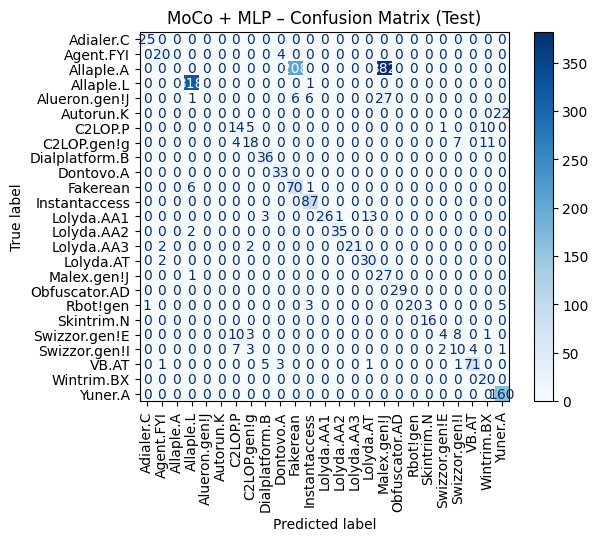

Class Adialer.C ROC-AUC: 1.0000
Class Agent.FYI ROC-AUC: 0.9999
Class Allaple.A ROC-AUC: 0.9792
Class Allaple.L ROC-AUC: 1.0000
Class Alueron.gen!J ROC-AUC: 0.8138
Class Autorun.K ROC-AUC: 0.9806
Class C2LOP.P ROC-AUC: 0.9828
Class C2LOP.gen!g ROC-AUC: 0.9887
Class Dialplatform.B ROC-AUC: 1.0000
Class Dontovo.A ROC-AUC: 1.0000
Class Fakerean ROC-AUC: 0.9945
Class Instantaccess ROC-AUC: 0.9999
Class Lolyda.AA1 ROC-AUC: 0.9979
Class Lolyda.AA2 ROC-AUC: 1.0000
Class Lolyda.AA3 ROC-AUC: 1.0000
Class Lolyda.AT ROC-AUC: 0.9994
Class Malex.gen!J ROC-AUC: 0.7928
Class Obfuscator.AD ROC-AUC: 1.0000
Class Rbot!gen ROC-AUC: 0.9940
Class Skintrim.N ROC-AUC: 1.0000
Class Swizzor.gen!E ROC-AUC: 0.9808
Class Swizzor.gen!I ROC-AUC: 0.9566
Class VB.AT ROC-AUC: 0.9984
Class Wintrim.BX ROC-AUC: 0.9991
Class Yuner.A ROC-AUC: 0.9901
Macro-average ROC-AUC: 0.9779


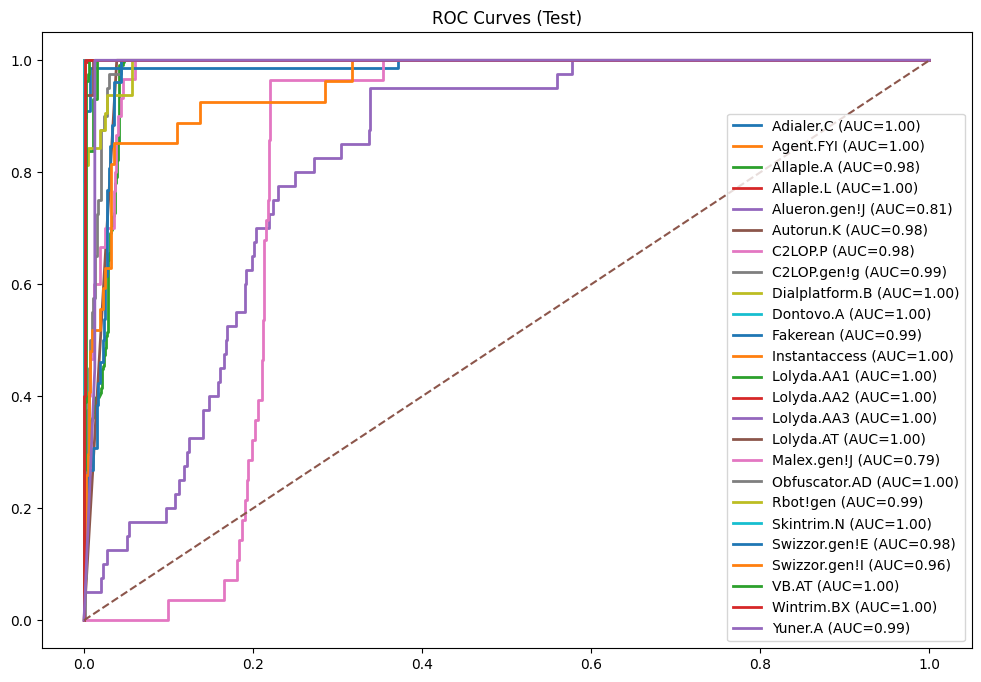

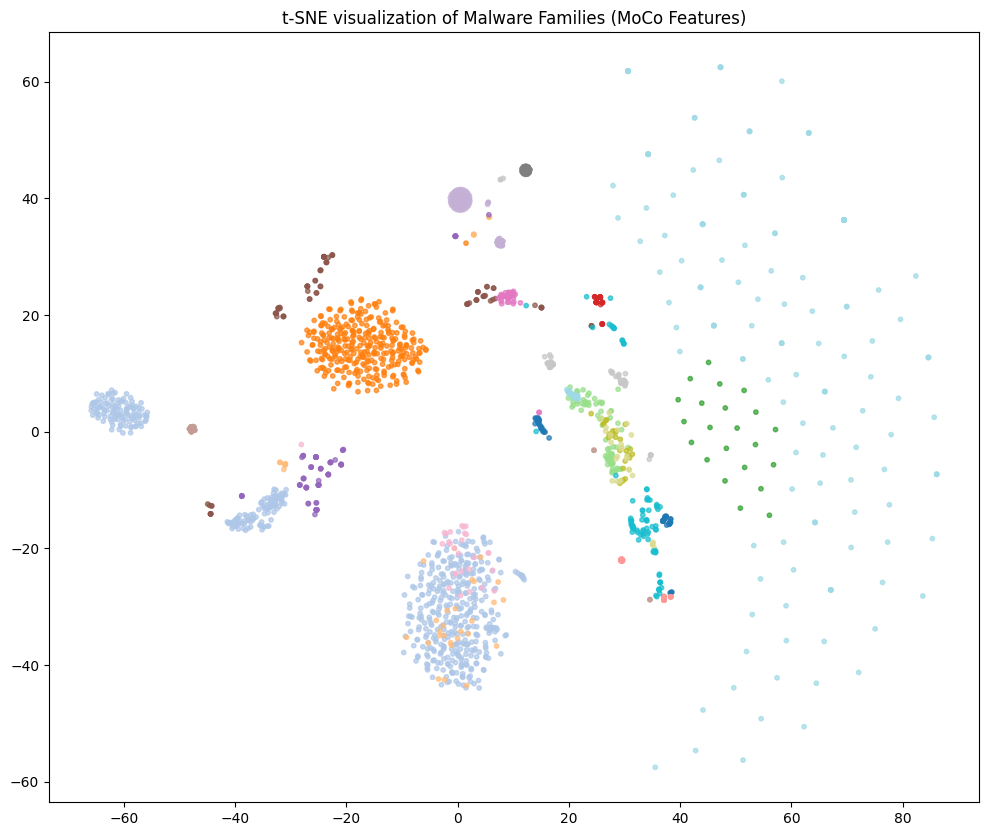

In [11]:

# -----------------------------
# 9) Confusion Matrix + ROC-AUC + t-SNE
# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20,20))
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, values_format='d')
plt.title("MoCo + MLP – Confusion Matrix (Test)"); plt.show()

num_classes = len(test_dataset.classes)
labels_onehot = label_binarize(all_labels, classes=np.arange(num_classes))
roc_auc_per_class = roc_auc_score(labels_onehot, all_probs, average=None)
for i, cls in enumerate(test_dataset.classes):
    print(f"Class {cls} ROC-AUC: {roc_auc_per_class[i]:.4f}")
print(f"Macro-average ROC-AUC: {roc_auc_score(labels_onehot, all_probs, average='macro'):.4f}")

plt.figure(figsize=(12, 8))
for i, cls in enumerate(test_dataset.classes):
    fpr, tpr, _ = roc_curve(labels_onehot[:, i], np.array(all_probs)[:, i])
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'--'); plt.legend(); plt.title("ROC Curves (Test)"); plt.show()

# t-SNE
all_feats = []
with torch.no_grad():
    for images, labels in test_loader:
        feats = backbone(images.to(device))
        all_feats.append(feats.cpu())
all_feats = torch.cat(all_feats, dim=0).numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeds = tsne.fit_transform(all_feats)
plt.figure(figsize=(12,10))
plt.scatter(embeds[:,0], embeds[:,1], c=all_labels, cmap="tab20", s=10, alpha=0.7)
plt.title("t-SNE visualization of Malware Families (MoCo Features)")
plt.show()